<a href="https://colab.research.google.com/github/CamilaSV/Fake-News-Detector/blob/main/RealOrFakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Real Or Fake News</h1>
<h2>Team 1</h2>
<h5>
  First, we need to install some of the dependencies needed for this project, such as NLTK, Pandas, Numpy, etc.
</h5>

In [ ]:
# Import wordcloud
!pip install -q wordcloud
import wordcloud
from wordcloud import WordCloud

# Import natural language toolkit items
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Import necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob, os
import io
import unicodedata
import numpy as np
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### **Data Upload**

Upload the `EntireDataset.csv` file to read it:

In [ ]:
from google.colab import files
uploaded = files.upload()

Mounted at /content/drive/


If the file was uploaded correctly, we read the data and print some of the values to ensure the data is correct.

In [ ]:
df = pd.read_csv('EntireDataset.csv', encoding='ISO-8859-1')
df

,headline,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0
...,...,...
30308,Frenzied Trump Supporters Admit TheyÕd Be Just...,1
30309,Ruby Tuesday Waiter Warns Jill Stein Her Green...,1
30310,Teen Pregnancy Rate Prompting More High School...,1
30311,Jurisprudence Fetishist Gets Off On Technicality,1


### **Word Cloud**

Seeing if by a quick inspection, there's any differences in wordcloud for the real news and fake news headlines.

In [ ]:
dfReal = df[df.label == 0]
dfFake = df[df.label == 1]

Below is the wordcloud for **real news**:

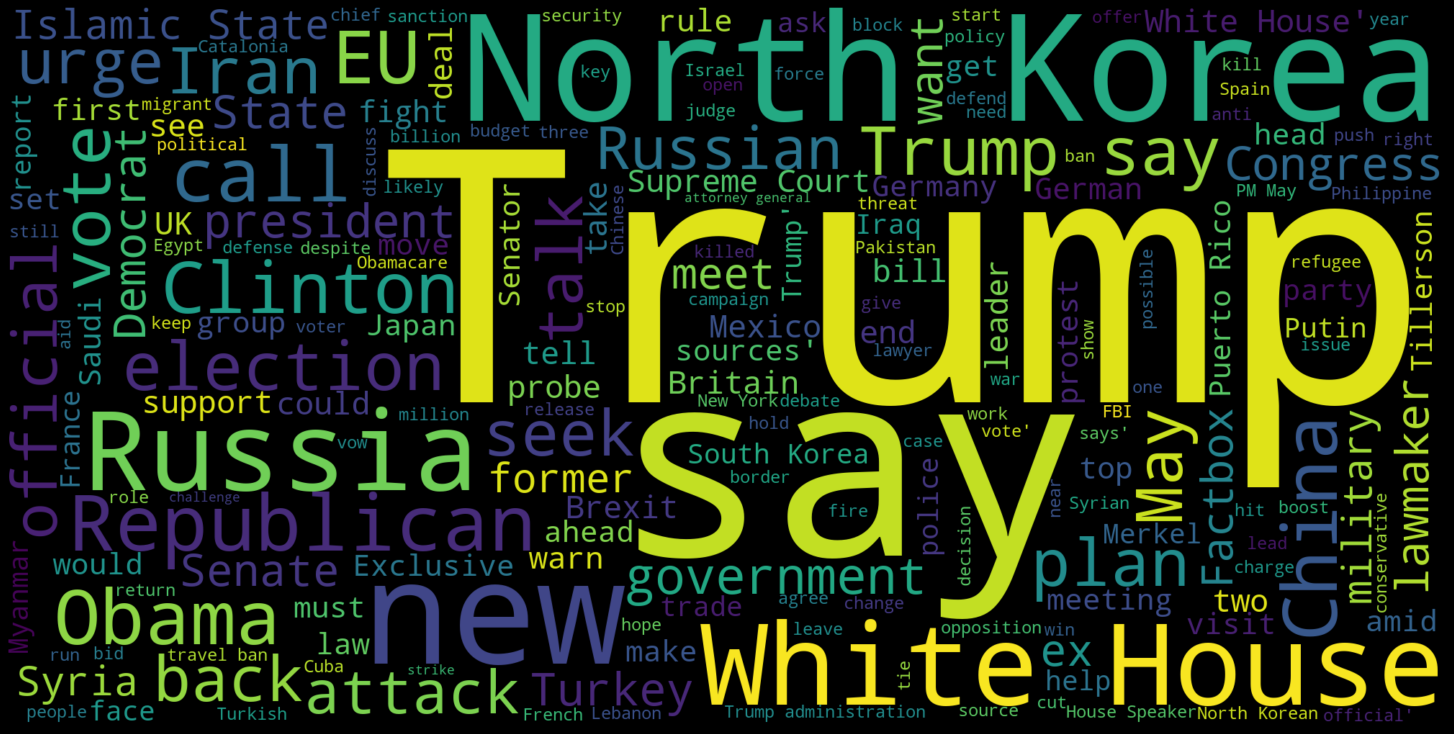

In [ ]:
text = ''

# Get all the headlines from the real news
for news in dfReal.values:
  text += f"  {news}"

# Create a wordcloud by specifying its width, height, background color, and
# stopwords to be discarded
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english")))

# Generate the wordcloud on the given text
wordcloud.generate(str(text))

# Create the plot by specifying width and height in inches, as well as colors
# to be used
fig = plt.figure(
    figsize = (20,10),
    facecolor = 'k',
    edgecolor = 'k')

# Show the word cloud that was generated
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')         # Turn off the plot axis
plt.tight_layout(pad=0) # Set padding to 0
plt.show()              # Show the plot
del text

Below is the wordcloud for **fake news**:

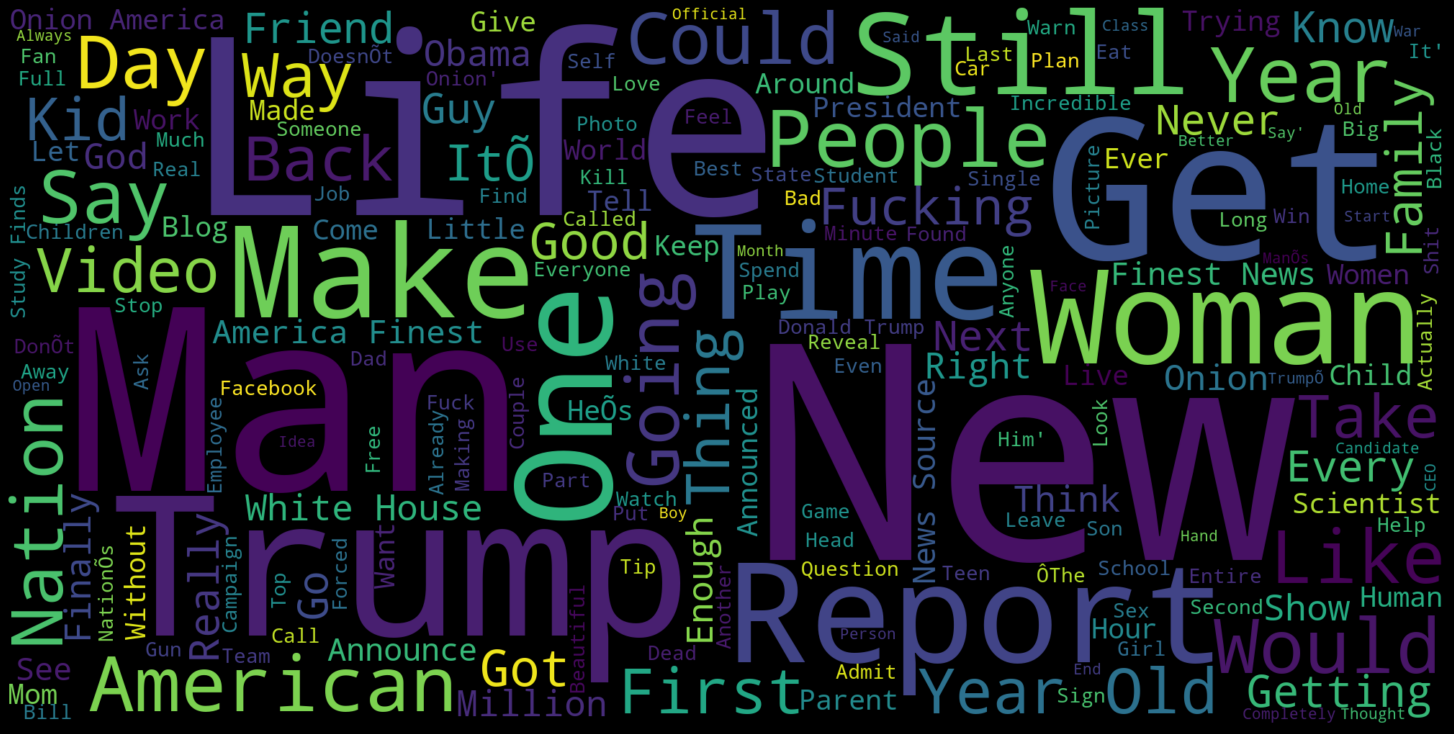

In [ ]:
text = ''

# Get all the headlines from the fake news
for news in dfFake.values:
  text += f"  {news}"

# Use the same wordcloud from before on the new text
wordcloud.generate(str(text))

# Create the plot by specifying width and height in inches, as well as colors
# to be used
fig = plt.figure(
    figsize = (20,10),
    facecolor = 'k',
    edgecolor = 'k')

# Show the word cloud that was generated
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

### **Tokenizing, Stemming, and Vectorizing**

Now, we create a function to break each headline into its own tokenized version, remove the stop words, and apply stemming:

In [ ]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

# Create a set of all stop words
all_stop_words = set(nltk.corpus.stopwords.words("english"))

# Create a regex tokenizer variable to remove punctuation
regex_tokenizer = RegexpTokenizer(r'\w+')

# Tokenizes and stems inputed headline
def tokenize_and_stem(headline):
  porter = PorterStemmer()

  # Tokenize the full headline
  full_headline = regex_tokenizer.tokenize(headline)

  # Array to maintain the cleaned, tokenized headline
  cleaned_headline = []

  # For every word in the tokenized headline
  for word in full_headline:

    # Lower case the word
    word = word.lower()

    # If the word is not in the stopwords set, stem and append it
    if word not in all_stop_words:
      stemmed_word = porter.stem(word)
      cleaned_headline.append(stemmed_word)

  # Return the cleaned headline
  return cleaned_headline

Next, we create a function for performing Tfidf vectorization:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Gets a tfidf vectorizer
def get_tfidf_vectorizer(max_features, ngram_min, ngram_max):
  return TfidfVectorizer(
      analyzer='word',                    # Need word analyzer for tokenizer
      max_features=max_features,          # Create a max amount of features
      ngram_range=(ngram_min, ngram_max), # Create a range of ngrams
      tokenizer=tokenize_and_stem,        # Add tokenizer and stemming function
  )

We also created data splitting function that is standardized and used accross all models:

In [ ]:
from sklearn.model_selection import train_test_split

# Splits data, returning an array where index:
#   0 = X_train
#   1 = X_test
#   2 = y_train
#   3 = y_test
def get_split_data(features, labels):
  return train_test_split(
      features,           # The features that we are splitting
      labels,             # The labels of the headlines
      stratify=labels,    # Stratify based on the labels
      test_size=0.20,     # Test size of 20%
      random_state=1      # Use random state of 1
  )

We use all of the created functions to vectorize our input and get training and testing data:

In [ ]:
# Create the labels for splitting the data as a numpy array
labels = df['label']
labels = np.array(labels)

# Get the tf-idf vectorizer that will return the top 2000 words
vectorizer = get_tfidf_vectorizer(2000, 1, 5)

# Fit and transform the headlines from the dataset using the vectorizer to get
# a sparse matrix
features = vectorizer.fit_transform(df['headline'])

# Return a dense array of features
features_dense = np.array(features.todense())

# Split the dense features
X_train, X_test, y_train, y_test = get_split_data(features_dense, labels)

# Split the sparse features
X_train_sparse, X_test_sparse, y_train_sparse, y_test_sparse = get_split_data(features, labels)

In [ ]:
all_features = vectorizer.get_feature_names()
for i in range(0, 1000, 5):
  print(all_features[i:i + 5])

Lastly, we make a function for cross validating the models on to see what the optimal values are for the parameters:

In [ ]:
# Import cross validation & confusion matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

# Performs 5 fold validation on a model with Tf-Idf vectorized values that are
# either dense or sparse
def cross_validate_model(model, verbose=1, dense=1):

  # If we're using the dense data:
  if (dense == 1):
    # Perform cross validation on model using dense Tf-Idf vectorized values
    score = cross_val_score(
        model,    # Use the inputed model
        X_train,  # Use the Tf-Idf training features
        y_train,  # Use the Tf-Idf training labels
        cv=5      # Perform 5 folds
    ).mean()

  # Otherwise, we're using the sparse data:
  else:
    # Perform cross validation on model using sparse Tf-Idf vectorized values
    score = cross_val_score(
        model,            # Use the inputed model
        X_train_sparse,   # Use the Tf-Idf training features
        y_train_sparse,   # Use the Tf-Idf training labels
        cv=5              # Perform 5 folds
    ).mean()

  # If verbose is equal to 1, we print the score
  if (verbose == 1):
    print("Average score on TF-IDF was: {:.3f}".format(score))

  # Return the mean of the scores
  return score

# Evaluates given model by training it and testing it on Tf-Idf vectorized
# values that are either sparse or dense
def evaluate_model(model, dense=1):

  # If we're using the dense data
  if (dense == 1):
    # Train and print the model results on dense Tf-Idf vectorized data
    model.fit(X_train, y_train)
    print("Accuracy on TF-IDF vectorized test set: {:.3f}".format(model.score(X_test, y_test)))

    # Plotting Confusion matrix for Tf-Idf values
    confusion_m = plot_confusion_matrix(
        model,    # The model we are plotting the confusion matrix for
        X_test,   # The features in the testing set
        y_test,   # The labels in the testing set
        # Normalize values to be between 0 and 1
        normalize='true',
    )

  # Otherwise, we're using the sparse data
  else:
    # Train and print the model results on sparse Tf-Idf vectorized data
    model.fit(X_train_sparse, y_train_sparse)
    print("Accuracy on TF-IDF vectorized test set: {:.3f}".format(model.score(X_test_sparse, y_test_sparse)))

    # Plotting Confusion matrix for Tf-Idf values
    confusion_m = plot_confusion_matrix(
        model,            # The model we are plotting the confusion matrix for
        X_test_sparse,    # The features in the testing set
        y_test_sparse,    # The labels in the testing set
        # Normalize values to be between 0 and 1
        normalize='true',
    )

  # Specify the figure size of the plot and show it
  plt.show()

  # Return the model fit with Tf-Idf data
  return model

### **Support Vector Machine**

For our SVM, we decided to cross validate all of the different kernels on our dataset to check which kernel worked best. We also used sparse data since dense data took hours to converge, if it converged at all.

In [ ]:
# Import SVM model
from sklearn import svm

# ----------------------------- Linear Kernel -----------------------------
# Create a linear SVM model
linear_svm = svm.SVC(kernel='linear')

# Perform cross validation on the linear SVM model with sparse data
print("\nSVM - Linear Kernel:")
cross_validate_model(linear_svm, verbose=1, dense=0)

# ----------------------------- Poly Kernel -----------------------------
# Create a poly SVM model
poly_svm = svm.SVC(kernel='poly')

# Perform cross validation on the poly SVM model with sparse data
print("\nSVM - Poly Kernel:")
cross_validate_model(poly_svm, verbose=1, dense=0)

# ----------------------------- RBF Kernel -----------------------------
# Create a rbf SVM model
rbf_svm = svm.SVC(kernel='rbf')

# Perform cross validation on the rbf SVM model with sparse data
print("\nSVM - RBF Kernel:")
cross_validate_model(rbf_svm, verbose=1, dense=0)

# ----------------------------- Sigmoid Kernel -----------------------------
# Create a sigmoid SVM model
sigmoid_svm = svm.SVC(kernel='sigmoid')

# Perform cross validation on the sigmoid SVM model with sparse data
print("\nSVM - Sigmoid Kernel:")
vals = cross_validate_model(sigmoid_svm, verbose=1, dense=0)


SVM - Linear Kernel:
Average score on TF-IDF was: 0.948

SVM - Poly Kernel:
Average score on TF-IDF was: 0.918

SVM - RBF Kernel:
Average score on TF-IDF was: 0.950

SVM - Sigmoid Kernel:
Average score on TF-IDF was: 0.946



Support Vector Machines - Using the following model:
SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Accuracy on TF-IDF vectorized test set: 0.952


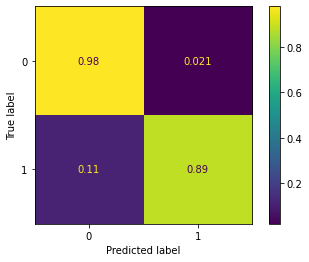

Precision: 0.979
Recall: 0.899
F1-Score: 0.937


In [ ]:
# Print the best model found
print('\nSupport Vector Machines - Using the following model:')
print(rbf_svm)

# Evaluate the model
svm_model = evaluate_model(rbf_svm, dense=0)
# Hand calculated based on the confusion matrix
print("Precision: 0.979")
print("Recall: 0.899")
print("F1-Score: 0.937")

### **Naïve Bayes**

We decided to use Multinomial Naïve Bayes because it works well with document classification (Using word counts), even for fractional counts such as Tf-Idf. We use cross validation to find the best alpha value.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create a tuple to store the best model and its result
best_model = (None, 0)

# Initiate an alpha value at 0.01
a = 0.01

# Try alpha values between 0.01 and 10
while (a <= 10):

  # Create the multinomial naive bayes model using the alpha value
  nb_model = MultinomialNB(alpha=a)

  # Cross validate the new model without printing any results
  results = cross_validate_model(nb_model, verbose=0, dense=0)

  # If the cross validation results for the Tf-Idf vectorized values on the new
  # model is greater than the best models result:
  if (results > best_model[1]):

    # Save the model, alpha value, and score on Tf-Idf vectorized values
    best_model = (nb_model, results)

  # Increment the alpha value by 0.01 every time
  a += 0.01

# Store the Naïve Bayes model we are using
nb_model = best_model[0]



Naïve Bayes - Using the following model:
MultinomialNB(alpha=0.37000000000000016, class_prior=None, fit_prior=True)
Accuracy on TF-IDF vectorized test set: 0.933


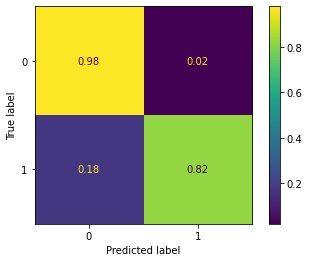

Precision: 0.98
Recall: 0.844
F1-Score: 0.906


In [ ]:
# Print the best model found
print("\nNaïve Bayes - Using the following model:")
print(nb_model)

# Evaluate the model
nb_model = evaluate_model(nb_model, dense=0)
# Hand calculated based on the confusion matrix
print("Precision: 0.98")
print("Recall: 0.844")
print("F1-Score: 0.906")

### **Decision Tree & Forest**

For the single decision tree classifier, we are using different input values such as max depth and criterion. Therefore, to ensure the best results, we are cross validating the use of these values to get the best parameters.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Create a tuple to store the best model and its result
best_model = (None, 0)

# Try depth values between 1 and 100
for depth in range(1, 101):

  # Create the decision tree model using the depth and entropy
  tree_entropy = DecisionTreeClassifier(
      max_depth=depth,
      criterion='entropy',
      random_state=888
  )

  # Create the decision tree model using the depth and gini
  tree_gini = DecisionTreeClassifier(
      max_depth=depth,
      criterion='gini',
      random_state=888
  )

  # Cross validate all of the models and pull the score on the Tf-Idf vectorized
  # values
  results_entropy = cross_validate_model(tree_entropy, verbose=0, dense=0)
  results_gini = cross_validate_model(tree_gini, verbose=0, dense=0)

  # Check if the best model stored is better than the new entropy model
  if (best_model[1] < results_entropy):
    best_model = (tree_entropy, results_entropy)

  # Check if the best model stored is better than the new gini model
  if (best_model[1] < results_gini):
    best_model = (tree_gini, results_gini)

# Store the Tree Classifier model we are using
tree_model = best_model[0]


Decision Tree Classifier - Using the following model:
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=96, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=888, splitter='best')
Accuracy on TF-IDF vectorized test set: 0.897


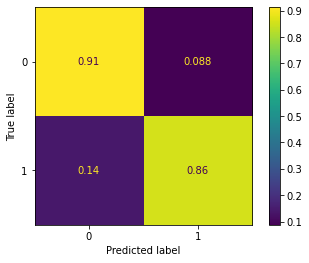

Precision: 0.911
Recall: 0.866
F1-Score: 0.887


In [ ]:
# Print the best model found
print("\nDecision Tree Classifier - Using the following model:")
print(tree_model)

# Evaluate the model
tree_model = evaluate_model(tree_model, dense=0)

#Hand calculated afterwards
print("Precision: 0.911")
print("Recall: 0.866")
print("F1-Score: 0.887")

For the random forest classifier, we are using the best parameters from the single decision tree, and cross validating the best maximum amount of trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a tuple to store the best model and its result
best_model = (None, 0)

# Try maximum tree values between 1 and 100
for trees in range(1, 101):

  # Create a random forest classifier using some maximum number of trees
  forest_model = RandomForestClassifier(
      random_state=888,
      max_depth=96,
      criterion='gini',
      n_estimators=trees)

  # Cross validate the new model without printing any results
  results = cross_validate_model(forest_model, verbose=0, dense=0)

  # If the cross validation results for the Tf-Idf vectorized values on the new
  # model is greater than the best models result:
  if (results > best_model[1]):

    # Save the model, alpha value, and score on Tf-Idf vectorized values
    best_model = (forest_model, results)

# Store the forest classifier model we are using
forest_model = best_model[0]


Decision Tree - Random Forest:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=96, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=91,
                       n_jobs=None, oob_score=False, random_state=888,
                       verbose=0, warm_start=False)
Accuracy on TF-IDF vectorized test set: 0.920


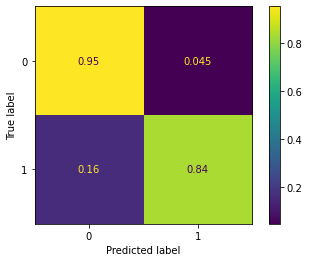

Precision: 0.954
Recall: 0.855
F1-Score: 0.901


In [ ]:
# Print the best model found
print("\nDecision Tree - Random Forest:")
print(forest_model)

# Evaluate the model
forest_model = evaluate_model(forest_model, dense=0)
print("Precision: 0.954")
print("Recall: 0.855")
print("F1-Score: 0.901")

### **Deep Learning**

For our NN model, we are using just one hidden layer, which we chose after finding out only one hidden layer is needed in most cases. It is producing two outputs for binary classification.

In [ ]:
# Import Keras library
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.utils import to_categorical

# define the model
mlp = Sequential()
mlp.add(Input(shape=(2000,)))
mlp.add(Dense(1001, activation='relu'))
mlp.add(Dense(2, activation='sigmoid'))

# compile the model
mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Make the labels categorical (Choose one of two choices)
y_train_categorical = to_categorical(y_train,2)
y_test_categorical = to_categorical(y_test,2)

# fit the model on the dataset
results = mlp.fit(X_train, y_train_categorical, epochs=8, batch_size=20, verbose=0)

In [ ]:
# Print the model used
print("\nDeep Neural Network - Using the following model:")
mlp.summary()

# Evaluate the model
_, accuracy = mlp.evaluate(X_test, y_test_categorical, verbose=0)
print("Accuracy on test set: {:.3f}".format(accuracy))


Deep Neural Network - Using the following model:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1001)              2003001   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2004      
Total params: 2,005,005
Trainable params: 2,005,005
Non-trainable params: 0
_________________________________________________________________
Accuracy on test set: 0.943


### **Text Input**

The purpose of this input is for a user to test our models. A user can put in a headline, select whether or not it is a real news headline, and select the model they want to use. The headline is then processed using Tf-Idf and ran on the model to see what the output is. Try it out below!

In [ ]:
Headline = 'Major Things Your Teacher Glossed Over In Sex Ed' #@param {type:"string"}
Label = 'False' #@param ["True", "False"]
Model = 'Neural Network' #@param ["SVM", "Naive Bayes", "Decision Tree", "Decision Forest", "Neural Network"]

# Create an array of the tokenized headline
inputed_features = vectorizer.transform([Headline])

# Print the information about the headline
print("The headline is:\n\"" + Headline + "\"\n")

# Use the model we need to
if (Model == 'SVM'):
  prediction = svm_model.predict(inputed_features)

elif (Model == 'Naive Bayes'):
  prediction = nb_model.predict(inputed_features)

elif (Model == 'Decision Tree'):
  prediction = tree_model.predict(inputed_features)

elif (Model == 'Decision Forest'):
  prediction = forest_model.predict(inputed_features)

elif (Model == 'Neural Network'):
  prediction = mlp.predict(np.array(inputed_features.todense()))

print("The " + Model + " model predicted:")

# If the model was not a neural network:
if (Model != 'Neural Network'):
  if (prediction[0] == 0):
    print('TRUE')

  else:
    print('FALSE')

# Otherwise:
else:
  if (prediction[0][1] > prediction[0][0]):
    print('FALSE')
  else:
    print('TRUE')

The headline is:
"Major Things Your Teacher Glossed Over In Sex Ed"

The Neural Network model predicted:
FALSE
